# Advertising Experiment
 
#### Background Information

A randomized experiment was conducted and the results are in 'Training.csv'. The data for this project consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $\$10$. Since it costs the company $\$0.15$ to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

The goal in this notebook is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, the goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is $\$10$ times the total number of purchasers that received the promotion minus $\$0.15$ times the number of promotions sent out, minus $\$10$ times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

Build a model to select the best customers to target that maximizes the Incremental
Response Rate and Net Incremental Revenue.

Below you can find the training data provided.  We explore the data and different optimization strategies.


In [2]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


## Data Inspection and Distribution of Promotion

Check of the dtypes, shape, missing and unique values.

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [4]:
train_data.nunique()

ID           84534
Promotion        2
purchase         2
V1               4
V2           84518
V3              40
V4               2
V5               4
V6               4
V7               2
dtype: int64

In [5]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


To find if this offer had an incremental response, we first check the distribution of the the promotion.

In [6]:
prom_count = train_data.groupby(['Promotion', 'purchase']).count()
prom_count

ID     V1     V2     V3     V4     V5     V6     V7
Promotion purchase                                                        
No        0         41851  41851  41851  41851  41851  41851  41851  41851
          1           319    319    319    319    319    319    319    319
Yes       0         41643  41643  41643  41643  41643  41643  41643  41643
          1           721    721    721    721    721    721    721    721

## Analysis of experiment results

First we analyze the results of the experiment and identify the effect of the Treatment on
product purchase and Net Incremental Revenue. We verify if the observed Incremental Response Rate (IRR) and Net Incremental Revenue (NRR) are statistically significant.

Recall that these two metrics are defined as follows.

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

$$NIR   = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl} $$

In [7]:
purch_treat = prom_count.iloc[3][0]
cust_treat = purch_treat + prom_count.iloc[2][0]
purch_ctrl = prom_count.iloc[1][0]
cust_ctrl = purch_ctrl + prom_count.iloc[0][0]

#the observeed irr is
obs_irr = purch_treat/cust_treat  - purch_ctrl/cust_ctrl
#the observed nir is
obs_nir = (10*purch_treat - 0.15*cust_treat) - 10*purch_ctrl

In [8]:
obs_irr, obs_nir

(0.009454547819772702, -2334.5999999999995)

Let's bootstrap this sample to simulate the sampling distribution of the IRR and NIR.  Here we will take 20 percent of the whole data = (16907) for the sub-sample size for bootstrapping.

In [9]:
train_data.shape[0]*.2

16906.8

In [10]:
irr_sim=[]
nir_sim=[]
for _ in range(10000):
    b_samp = train_data.sample(16907, replace = True)
    prom_count_sim = b_samp.groupby(['Promotion', 'purchase']).count()
    purch_treat = prom_count_sim.iloc[3][0] 
    cust_treat = purch_treat + prom_count_sim.iloc[2][0]
    purch_ctrl = prom_count_sim.iloc[1][0]
    cust_ctrl = purch_ctrl + prom_count_sim.iloc[0][0]
    irr = purch_treat/cust_treat  - purch_ctrl/cust_ctrl
    nir = (10*purch_treat - 0.15*cust_treat) - 10*purch_ctrl
    irr_sim.append(irr)
    nir_sim.append(nir)

Next we compute the $p$-value for our statistics $IRR$ and $NIR$, by simulating the distribution under the null hypothesis and then finding the probability that our statistic came from that distribution. To simulate the null, we'll create a normal distribution with the same mean, standard devation and size as our simulated sampling distribution.

In [11]:
null_vals_irr = np.random.normal(sum(irr_sim)/16907, np.array(irr_sim).std(), len(irr_sim))

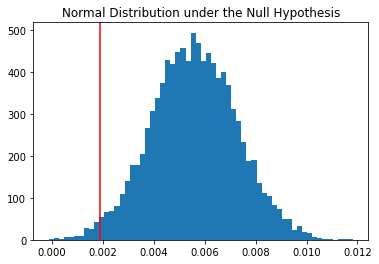

In [12]:
plt.hist(null_vals_irr, bins =60)
plt.axvline(obs_irr*16907/train_data.shape[0], color = 'red')
plt.title("Normal Distribution under the Null Hypothesis");

The $p$-value for the $IRR$ is given by

In [13]:
p_val_IRR = (obs_irr * .2 > null_vals_irr).mean()
p_val_IRR

0.0145

We test the corresponding null hypothesis for the $NIR$.

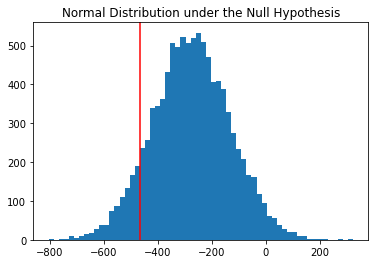

In [14]:
null_vals_nir = np.random.normal(sum(nir_sim)/16907, np.array(nir_sim).std(), np.array(nir_sim).size)
plt.hist(null_vals_nir, bins=60)
plt.axvline(obs_nir *  16907/train_data.shape[0], color = 'red')
plt.title("Normal Distribution under the Null Hypothesis");

In [15]:
p_val_NIR = (obs_nir *.2 > null_vals_nir).mean()
p_val_NIR <0.025

False

The observed values of $IRR$ is statistically significant based on the $p$-value of 0.0139 and an $\alpha$ of 0.025 (adopting the Bonferroni Correction). The observed value of $NIR$ does not appear to be statistically significant based on the $p$-value computed.

## Results summary

The incremental response rate observed in the data shows that the promotion had a statisically significant impact in increasing the number of customers who purchased the product. 

The observed net incremental revenue, however, is negative but not necessarily statistically significant. The advertising promotion is bringing more customers to purchase the product but given the promotion costs and the net revenue levels, it's possible to optimize the targeting of the promotion and maximize the $IRR$ and $NIR$.

## ML classification model

The following models aim at selecting the best customers to target and maximize the Incremental Response Rate and Net Incremental Revenue.

Note that the data is unbalanced as there are fewer rows with labels corresponding to purchases.

In [16]:
(train_data.purchase == 1).sum(), (train_data.purchase == 0).sum()

(1040, 83494)

Do deal with this unbalanced data, we will train a model using a subset of the data set where both labels for the response variables are equally represented.

In [17]:
import random
data_purchase_0 = train_data.loc[random.sample(set(train_data.purchase[train_data.purchase == 0].index), 1040)]
data_purchase_1 = train_data.loc[random.sample(set(train_data.purchase[train_data.purchase == 1].index), 1040)]
data_balanced = pd.concat([data_purchase_1, data_purchase_0])

We start by creating the explanatory variables $X$ and response variable $y$.

In [18]:
X = data_balanced.drop(['ID', 'Promotion','purchase'], axis=1)
y = data_balanced.purchase

#Standarize features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']] = scaler.fit_transform(X[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']])

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)

We implement a logistic regression model first and set a benchmark.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# Create logistic regression object
clf = LogisticRegression()
# Train model
LR_model = clf.fit(X_train, Y_train)

In [21]:
LR_model.score(X_train, Y_train)

0.5865039483129936

In [22]:
LR_model.score(X_test, Y_test)

0.5414847161572053

Now we try a support vector machine classfier.

In [23]:
from sklearn import svm, metrics
clf = svm.SVC()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(metrics.accuracy_score(Y_test, Y_pred))

0.5618631732168851


## Model selection using grid search

For a more systematic and effective approach, we use a grid search with a SVM, a Random Forest Classifier and a Logistic regression model with several parameters.

In [24]:
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

np.random.seed(0)

In [51]:
# Create a pipeline
pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create space of candidate learning algorithms and their hyperparameters
search_space = [{'classifier': [LogisticRegression()],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(0, 4, 10)},
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [10, 100, 1000],
                 'classifier__max_features': [1, 2, 3]},
               {'classifier': [svm.SVC()],
               'classifier__C': [1, 10, 100, 1000],
               'classifier__kernel': ['linear','rbf']}]

In [52]:
# Create grid search 
clf = GridSearchCV(pipe, search_space, cv=5, verbose=0)

In [53]:
# Fit grid search
best_model = clf.fit(X_train, Y_train)

In [56]:
# View best model
best_model.best_estimator_

Pipeline(steps=[('classifier', SVC(C=1, kernel='linear'))])

In [57]:
#view the accuracy score
best_model.score(X_test, Y_test)

0.5531295487627366

In [58]:
best_model.score(X_train, Y_train)

0.583632447954056

Finally, we generate a function that selects the best costumers to target and maximize the IRR and NIR.

In [33]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    y_pred = best_model.predict(df)
    
    promotion_yes_no = []
    for value in y_pred:
        if value == 0:
            promotion_yes_no.append("No")
        if value == 1:
            promotion_yes_no.append("Yes")
            
    promotion = np.asarray(promotion_yes_no)
    
    
    
    return promotion

In [44]:
promotion_strategy(X)

array(['Yes', 'Yes', 'No', ..., 'No', 'No', 'No'], dtype='<U3')